# Simple Linear Model using Tensorflow
by Teppei Suzuki

## Introduction

In this notebook, we will build a simple linear model using tensorflow. The dataset that we will be working with is the classic MNIST. MNIST is a collection of handwritten digits that is typically tested first on algortihms to bench mark its performance. There is an old saying that goes something like "if it ain't workin on MNIST, it ain't workin' at all". Here, we will see that our linear model can achieve 92.5% accuracy after training. 

## Setup

Let's first import some useful libraries along with tensorflow. 

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

C:\Users\tep\Anaconda3\envs\untitled1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let's now load the sample MNIST dataset.

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [13]:
data_row, data_col = 28, 28
data_shape = (data_row, data_col)
data_size = data_row * data_col
class_size = 10

## Examining the Data

Now that we have loaded the data, let's examine the contents to get a better understanding of what we are dealing with. As you can see, the data consists of training set and test set.

The training set is used solely for training the model. After the training is over, the test set is used to measure the accuracy of the trained model. Note that it is important to not use the test set for training. Here is a real life analogy: imagine you study for an exam by practicing past exams and when you take the real test, you notice that the test is exactly the same as one of the past exams that you've practiced on. Ofcourse, you did well, but we don't really know how you would do if the problems were slightly different.

In [14]:
print("Training-set:", len(data.train.labels))
print("Test-set:", len(data.test.labels))

Training-set: 55000
Test-set: 10000


Here we look at the first element in the training labels and training images. Notice that the size of the label is 10 (for 10 digit classification). The index where 1 is at is the correct value of the image. So for the printed example below, it is classifed as an 0.


In [15]:
print(data.train.labels[0])
print(data.train.images[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

In [16]:
print('size of a label:', len(data.train.labels[0]))
print('size of a data:', len(data.train.images[0]))

size of a label: 10
size of a data: 784


Lets plot some random images to see what they look like.

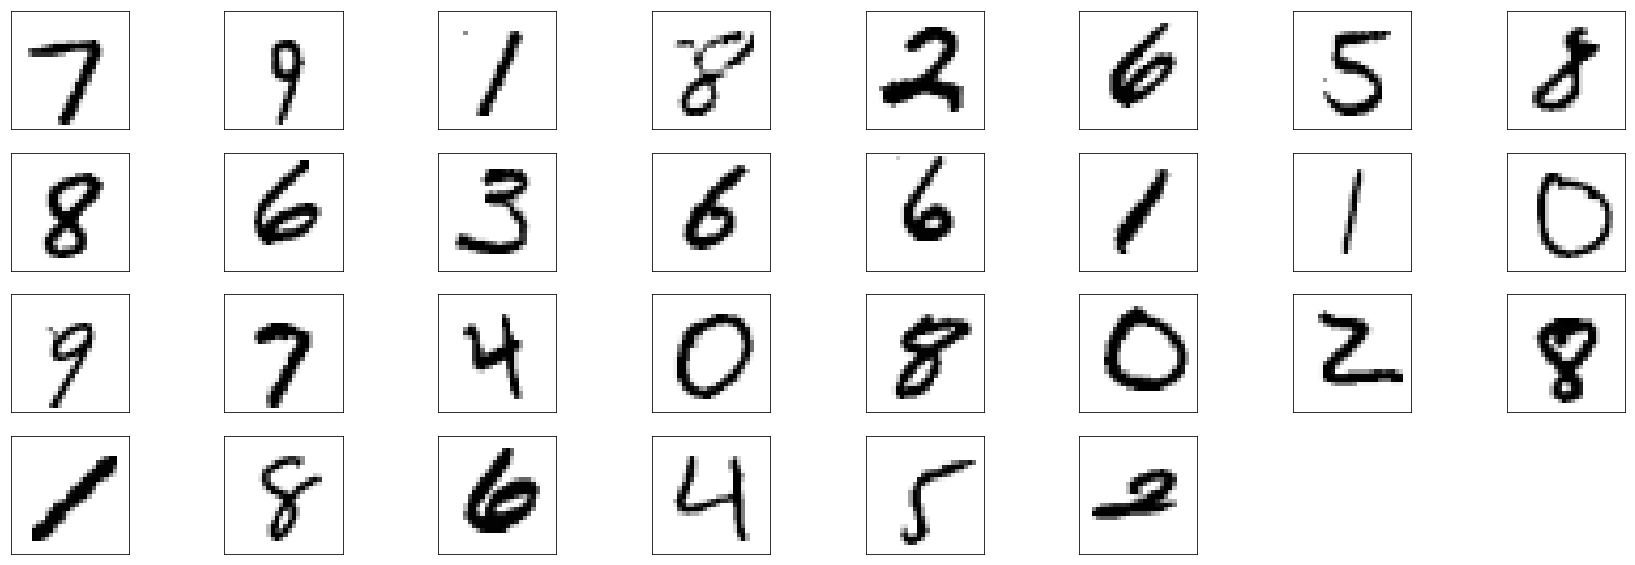

In [18]:
def plotRandomImages(data, num):
    # create a list with random ints of size num in the range(55000)
    random = np.random.randint(0, len(data.train.labels), size=num)
    
    # list of images
    images = []
    
    # add images to the list of images using the random ints
    # we have to reshape the array to 28x28 for correct plotting
    for i in range(num):
        index = random[i]
        images += [data.train.images[index].reshape(data_shape)]
    
    # plot the images
    plt.figure(figsize=(30,10))
    columns = 8
    
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image, cmap='binary')


plotRandomImages(data, 30)

## Building the Graph

Lets not build the linear model! I really enjoy working in tensorflow for tasks like this since it abstracts the underlying matrics multiplications that take place when building a graph. All we simply need to do is declare variable and placeholders to construct the graph.

We first define some functions that help us create the graph. We will go over what each function is doing as we call them.

In [19]:
def createPlaceholders(data_size, class_size):
    x = tf.placeholder(tf.float32, [None, data_size])
    y_one_hot = tf.placeholder(tf.float32, [None, class_size])
    y_true = tf.placeholder(tf.int64, [None])
    return x, y_one_hot, y_true

In [20]:
def createVariables(data_size, class_size):
    Weights = tf.Variable(tf.zeros([data_size, class_size]))
    bias = tf.Variable(tf.zeros([class_size]))
    return Weights, bias

In [21]:
def createPredictions(logits):
    y_pred_one_hot = tf.nn.softmax(logits)
    y_pred = tf.argmax(y_pred_one_hot, axis=1)
    return y_pred_one_hot, y_pred

In [22]:
def createCostFunc(logits, y_one_hot):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
    cost = tf.reduce_mean(cross_entropy)
    return cost

In [23]:
def createOptimizer(learn_rate, cost):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learn_rate).minimize(cost)
    return optimizer

In [24]:
def createAccuracy(y_pred, y_true):
    correct_prediction = tf.equal(y_pred, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

We first need to create some nodes that recieve input. In tensorflow, we call them placeholders.

Variable names:
* x : Input data
* y_one_hot : True value of the input where the non-zero ith entry indicates that the pic is number i
* y_true :  True integer value of the input image in range 0-9.

In [25]:
x, y_one_hot, y_true = createPlaceholders(data_size, class_size)

Next, we create the variables Weights and bias

In [26]:
Weights, bias = createVariables(data_size, class_size)

Lets now make the linear model which is y = data * weights + bias

In [28]:
logits = tf.matmul(x, Weights) + bias

Next, we need to create nodes for the predictions that our model is making.

In [35]:
y_pred_one_hot, y_pred = createPredictions(logits)

Lets create a cost function that we minimize along with an optimizer that fancily takes are of gradient decent on our model.

In [71]:
cost = createCostFunc(logits, y_one_hot)
optimizer = createOptimizer(.3, cost)

Lastly, we will create node for checking the model accuracy. 

In [72]:
accuracy = createAccuracy(y_pred, y_true)

### Training

Ok, that was a lot of work but not we are now ready to start training our model!

Lets first fire up our tensorflow session.

In [94]:
session = tf.Session()
init = tf.global_variables_initializer()
session.run(init)

In [95]:
num_iterations = 20001
batch_size = 100

data.test.cls = np.array([label.argmax() for label in data.test.labels])

feed_dict_test = {x: data.test.images,
                  y_one_hot: data.test.labels,
                  y_true: data.test.cls}

In [96]:
for i in range(num_iterations):
        if i % 4000 == 0:
                acc = session.run(accuracy, feed_dict=feed_dict_test)

                print("Iteration ", i, " accuracy = ", acc)
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        feed_dict_train = {x: x_batch,
                           y_one_hot: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

Iteration  0  accuracy =  0.098
Iteration  4000  accuracy =  0.9223
Iteration  8000  accuracy =  0.9232
Iteration  12000  accuracy =  0.9262
Iteration  16000  accuracy =  0.925
Iteration  20000  accuracy =  0.9258


As you can see, we were able to achive 92.6% accuracy from 20,000 iterations.